In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib


SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [2]:
DATA_CSV = "hourly_data_p_s1.csv"

MODEL_DIR = "rf_models_ps1"
SCALER_DIR = "rf_scalers_ps1"
PLOTS_DIR = "rf_plots_ps1"

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(SCALER_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

N_STEPS = 24
LAST_N_HOURS_TO_PLOT = 200

In [3]:
def create_sequences_rf(values, n_steps=24):
    X, y = [], []
    for i in range(len(values) - n_steps):
        X.append(values[i:i+n_steps].flatten())  # flatten
        y.append(values[i+n_steps])
    return np.array(X), np.array(y)


In [4]:
df = pd.read_csv(DATA_CSV, parse_dates=['localminute'])
df = df.sort_values('localminute').reset_index(drop=True)

house_ids = df['dataid'].unique()
print("Total houses:", len(house_ids))


Total houses: 14



Training Random Forest for House 26
Train samples: 2288
Test samples : 572
MAE = 0.4135 | RMSE = 0.6944


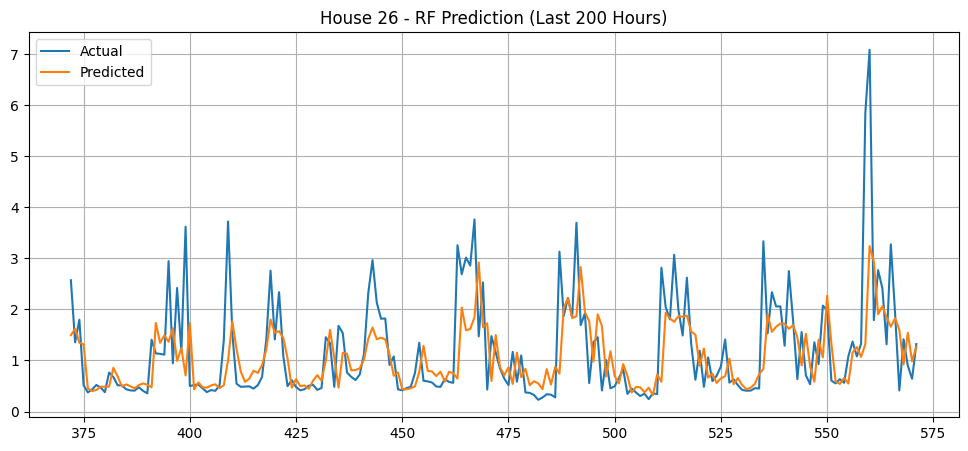

Saved: rf_plots_ps1/house_26_last200.png

Training Random Forest for House 222
Train samples: 2286
Test samples : 572
MAE = 1.0105 | RMSE = 1.4316


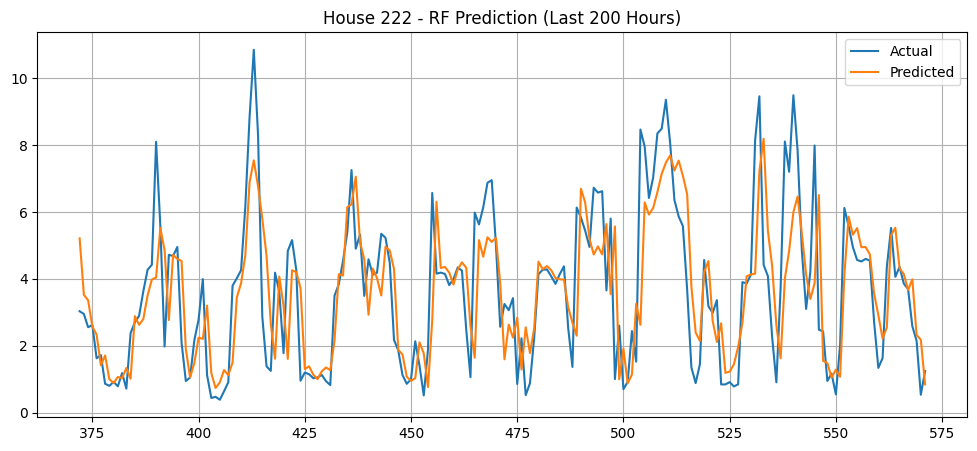

Saved: rf_plots_ps1/house_222_last200.png

Training Random Forest for House 187
Train samples: 2286
Test samples : 572
MAE = 0.5539 | RMSE = 0.8062


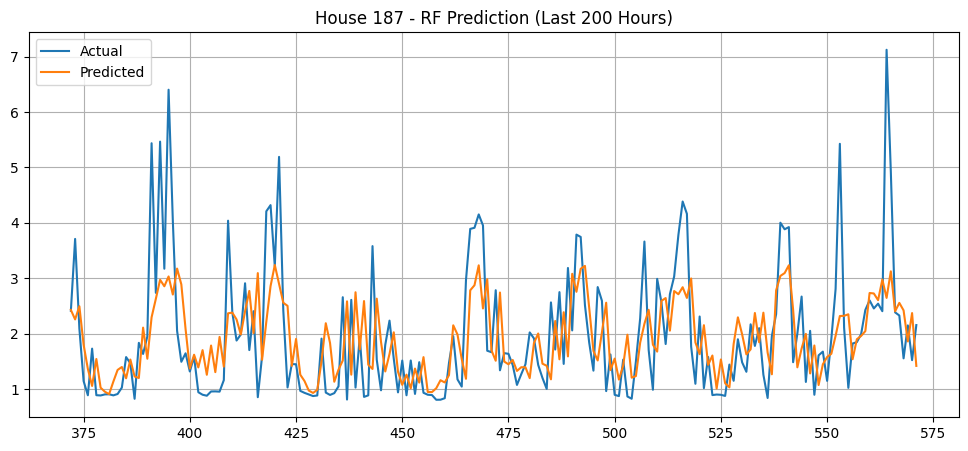

Saved: rf_plots_ps1/house_187_last200.png

Training Random Forest for House 171
Train samples: 2288
Test samples : 573
MAE = 0.2282 | RMSE = 0.3586


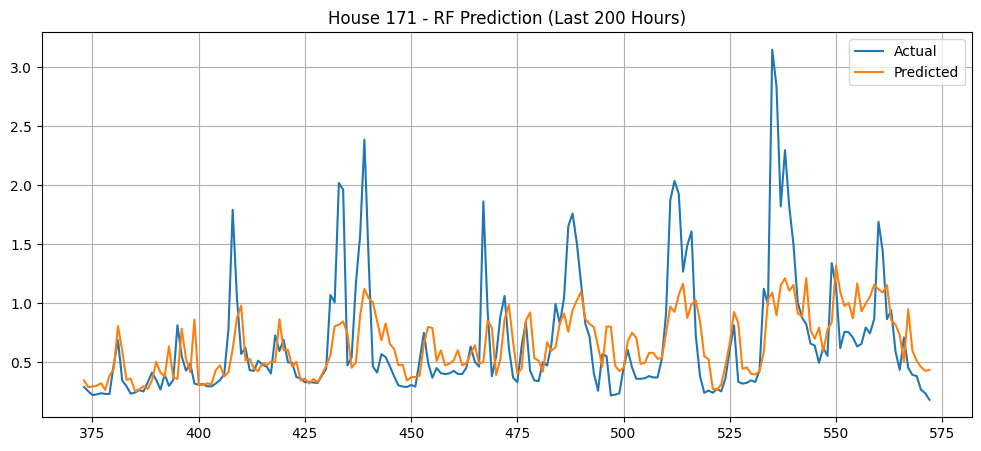

Saved: rf_plots_ps1/house_171_last200.png

Training Random Forest for House 370
Train samples: 2287
Test samples : 572
MAE = 0.5657 | RMSE = 0.8926


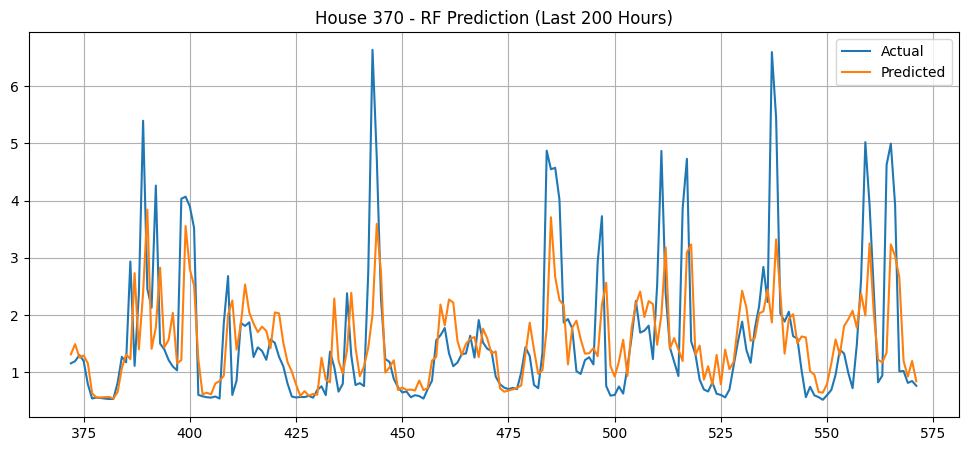

Saved: rf_plots_ps1/house_370_last200.png

Training Random Forest for House 115
Train samples: 2286
Test samples : 572
MAE = 0.1680 | RMSE = 0.2575


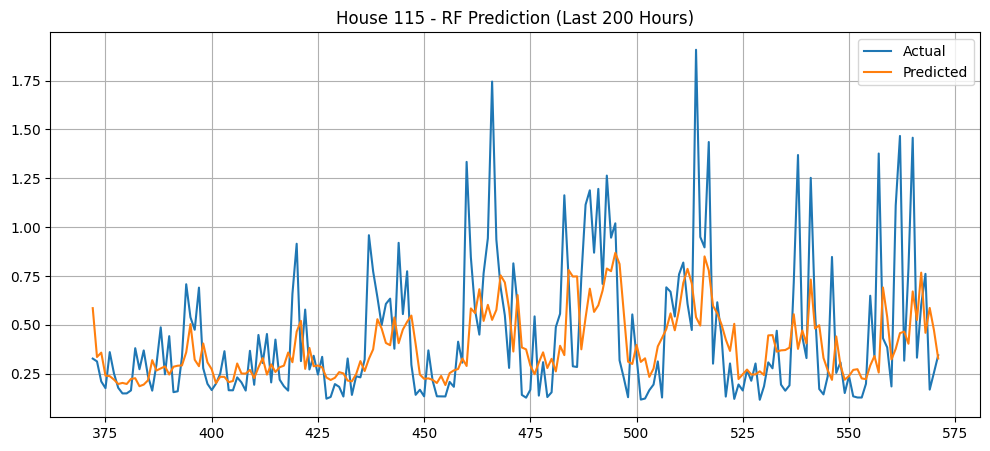

Saved: rf_plots_ps1/house_115_last200.png

Training Random Forest for House 114
Train samples: 2287
Test samples : 572
MAE = 0.3578 | RMSE = 0.5793


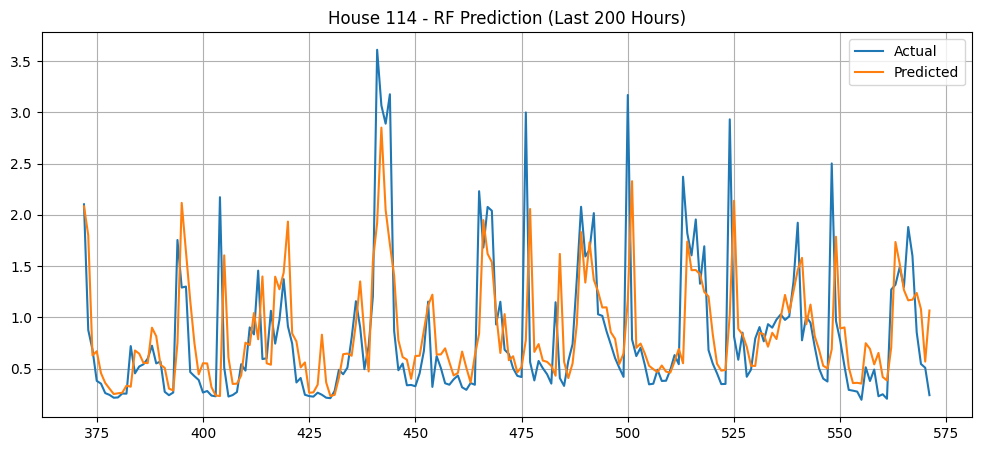

Saved: rf_plots_ps1/house_114_last200.png

Training Random Forest for House 101
Train samples: 2288
Test samples : 573
MAE = 0.2379 | RMSE = 0.5115


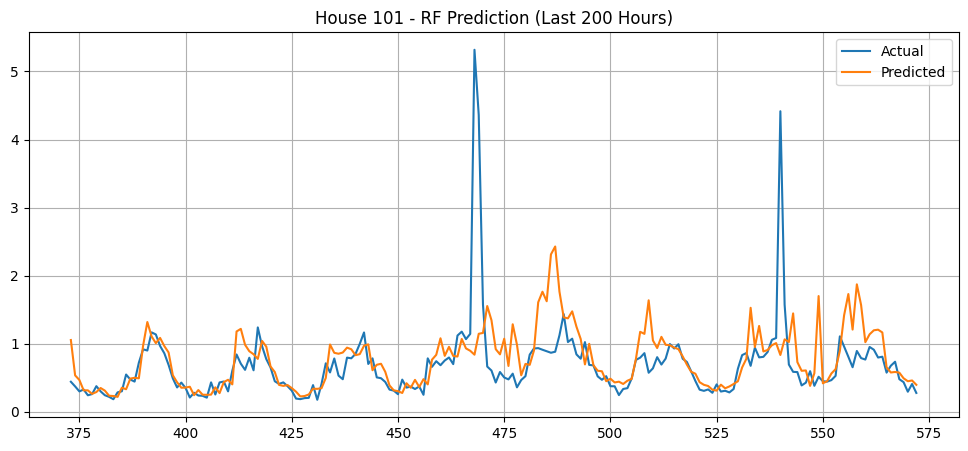

Saved: rf_plots_ps1/house_101_last200.png

Training Random Forest for House 93
Train samples: 2286
Test samples : 572
MAE = 0.3180 | RMSE = 0.5785


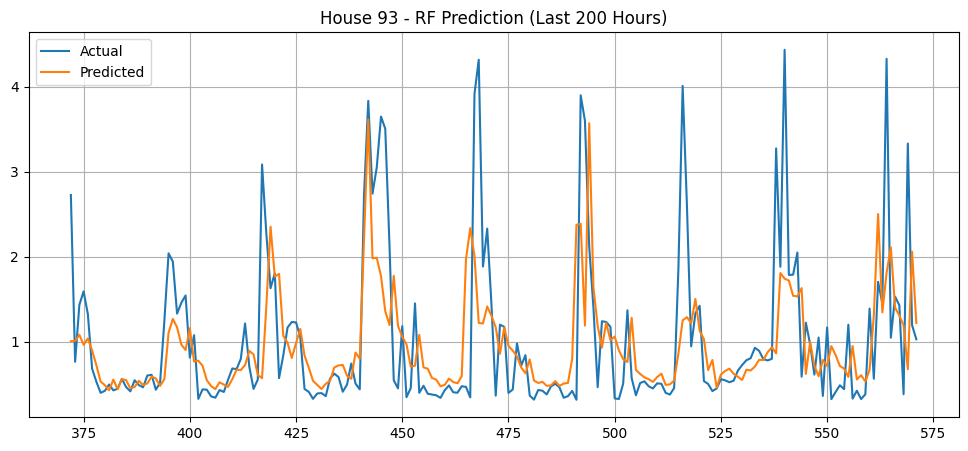

Saved: rf_plots_ps1/house_93_last200.png

Training Random Forest for House 379
Train samples: 2287
Test samples : 572
MAE = 0.5410 | RMSE = 1.0013


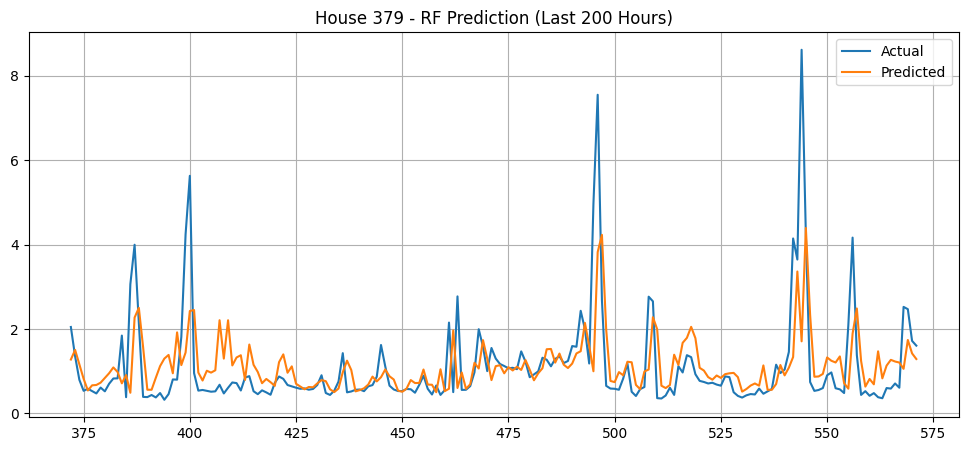

Saved: rf_plots_ps1/house_379_last200.png

Training Random Forest for House 86
Train samples: 2288
Test samples : 573
MAE = 0.3756 | RMSE = 0.7122


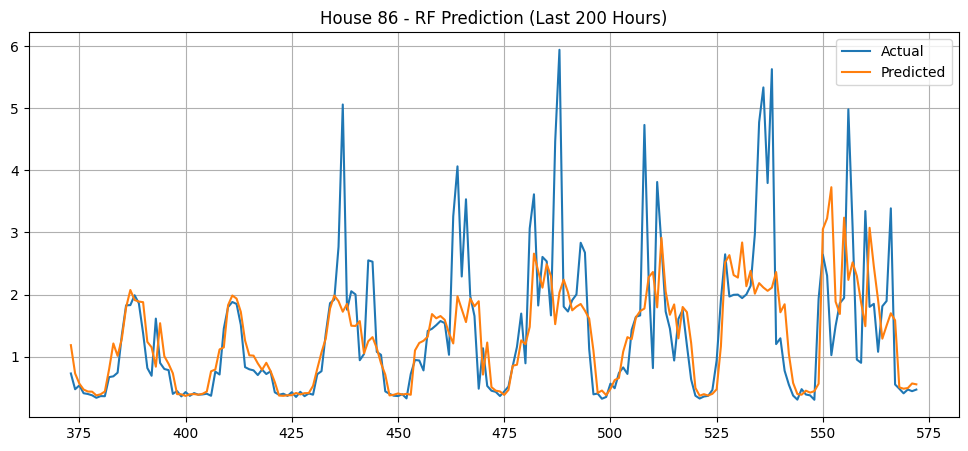

Saved: rf_plots_ps1/house_86_last200.png

Training Random Forest for House 77
Train samples: 2287
Test samples : 572
MAE = 0.3261 | RMSE = 0.5176


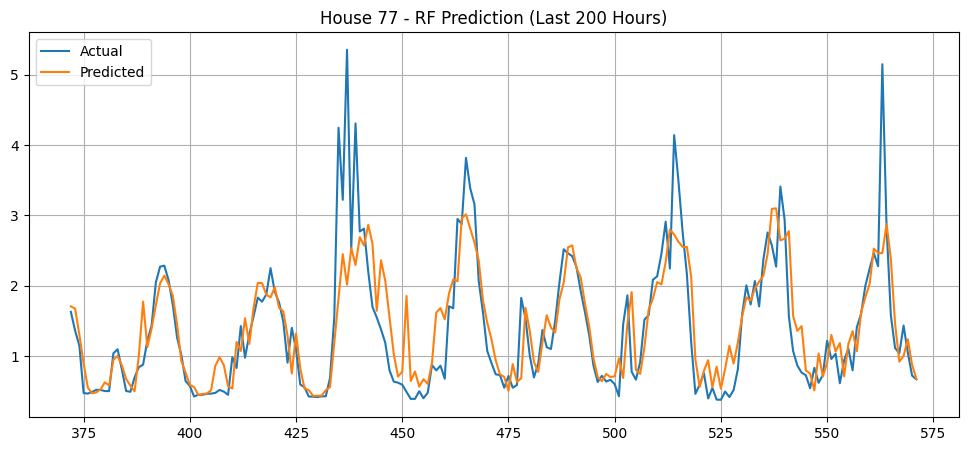

Saved: rf_plots_ps1/house_77_last200.png

Training Random Forest for House 59
Train samples: 2287
Test samples : 572
MAE = 0.2492 | RMSE = 0.4868


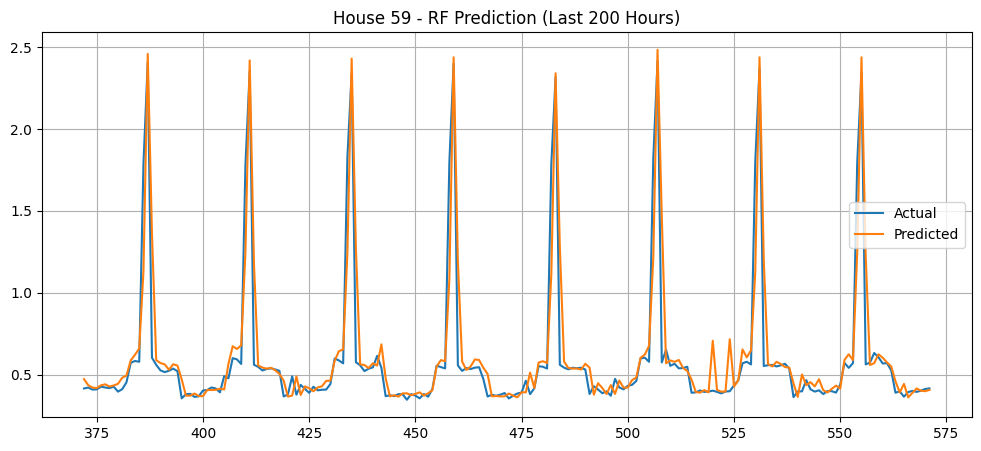

Saved: rf_plots_ps1/house_59_last200.png

Training Random Forest for House 252
Train samples: 2287
Test samples : 572
MAE = 0.5163 | RMSE = 0.8172


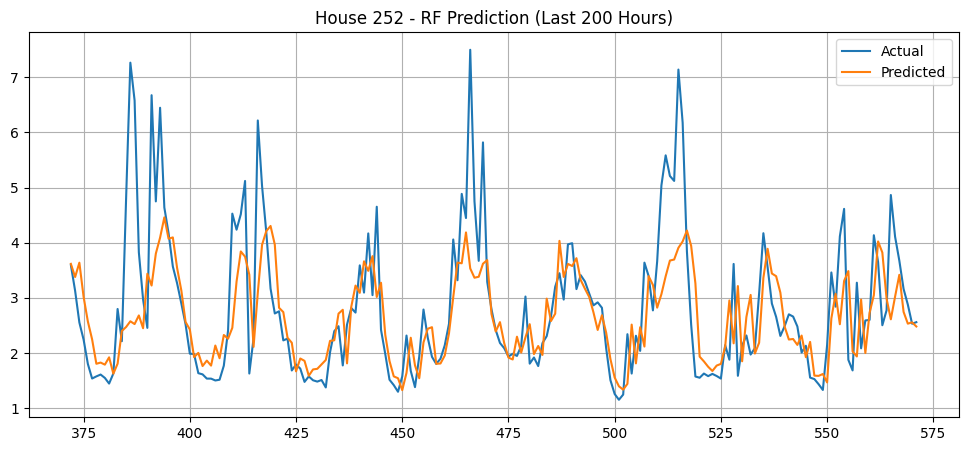

Saved: rf_plots_ps1/house_252_last200.png

 Random Forest training completed for all houses.
Saved metrics file: house_wise_rf_metrics_ps1.csv


In [6]:
results = []
for hid in house_ids:

    print("\n" + "="*60)
    print(f"Training Random Forest for House {hid}")

    house_df = df[df['dataid'] == hid].copy()
    house_df = house_df[['localminute', 'use']].dropna()
    house_df = house_df.sort_values('localminute')

    if len(house_df) < N_STEPS + 10:
        print("Skipping house (not enough data)")
        continue

    values = house_df['use'].values.reshape(-1, 1)

    # -------------------------------
    # Scaling
    # -------------------------------
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)
    joblib.dump(scaler, f"{SCALER_DIR}/scaler_{hid}.joblib")

    # -------------------------------
    # Sequences
    # -------------------------------
    X, y = create_sequences_rf(scaled, N_STEPS)

    # -------------------------------
    # Train/Test split
    # -------------------------------
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    print("Train samples:", len(X_train))
    print("Test samples :", len(X_test))

    # -------------------------------
    # Random Forest Model
    # -------------------------------
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        random_state=SEED,
        n_jobs=-1
    )

    model.fit(X_train, y_train.ravel())

    # Save model
    joblib.dump(model, f"{MODEL_DIR}/rf_house_{hid}.joblib")

    # -------------------------------
    # Prediction
    # -------------------------------
    preds_scaled = model.predict(X_test).reshape(-1, 1)
    y_test_scaled = y_test.reshape(-1, 1)

    preds = scaler.inverse_transform(preds_scaled)
    y_true = scaler.inverse_transform(y_test_scaled)

    # -------------------------------
    # Metrics
    # -------------------------------
    mae = mean_absolute_error(y_true, preds)
    rmse = np.sqrt(mean_squared_error(y_true, preds))

    print(f"MAE = {mae:.4f} | RMSE = {rmse:.4f}")

    results.append([hid, round(mae,4), round(rmse,4)])

    # -------------------------------
    # Plot last 200 hours
    # -------------------------------
    start_idx = split + N_STEPS
    time_index = house_df['localminute'].iloc[
        start_idx : start_idx + len(y_true)
    ].reset_index(drop=True)

    df_plot = pd.DataFrame({
        "time": time_index,
        "actual": y_true.flatten(),
        "predicted": preds.flatten()
    })

    df_last = df_plot.tail(LAST_N_HOURS_TO_PLOT)

    plt.figure(figsize=(12,5))
    plt.plot(df_last['actual'], label="Actual")
    plt.plot(df_last['predicted'], label="Predicted")
    plt.title(f"House {hid} - RF Prediction (Last 200 Hours)")
    plt.legend()
    plt.grid()

    plot_path = f"{PLOTS_DIR}/house_{hid}_last200.png"
    plt.savefig(plot_path, dpi=150)
    plt.show()

    print("Saved:", plot_path)

print("\n Random Forest training completed for all houses.")

# Save all metrics to CSV
results_df = pd.DataFrame(results, columns=["house_id", "mae", "rmse"])
results_df.to_csv("house_wise_rf_metrics_ps1.csv", index=False)
print("Saved metrics file: house_wise_rf_metrics_ps1.csv")

In [8]:
import pandas as pd
import numpy as np
import joblib
import os

# ---------------------------------------
# Sequence Creator (FIXED → 2D OUTPUT)
# ---------------------------------------
def create_sequences(data, seq_len=24):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len].flatten())   # FLATTEN HERE
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

# ---------------------------------------
# Load Data
# ---------------------------------------
df = pd.read_csv("hourly_data_p_s1.csv", parse_dates=["localminute"])
df = df.sort_values("localminute")

statistical_rows = []

# ---------------------------------------
# Loop Through Houses
# ---------------------------------------
for house_id in df["dataid"].unique():

    model_path = f"rf_models_ps1/rf_house_{house_id}.joblib"
    scaler_path = f"rf_scalers_ps1/scaler_{house_id}.joblib"

    if not os.path.exists(model_path):
        print(f"Skipping house {house_id} (model not found)")
        continue

    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)

    temp = df[df["dataid"] == house_id][["use"]].dropna()

    # -----------------------------------
    # Scale
    # -----------------------------------
    scaled = scaler.transform(temp.values)

    # -----------------------------------
    # Sequences
    # -----------------------------------
    X, y = create_sequences(scaled, 24)

    # -----------------------------------
    # Predict
    # -----------------------------------
    y_pred = model.predict(X).reshape(-1,1)

    # -----------------------------------
    # Inverse Scaling
    # -----------------------------------
    y_true = scaler.inverse_transform(y)
    y_pred = scaler.inverse_transform(y_pred)

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # -----------------------------------
    # Store Statistics
    # -----------------------------------
    statistical_rows.append([
        house_id,
        np.mean(y_true),
        np.mean(y_pred),
        np.std(y_true),
        np.std(y_pred),
        np.min(y_true),
        np.min(y_pred),
        np.max(y_true),
        np.max(y_pred),
        np.median(y_true),
        np.median(y_pred),
        pd.Series(y_true).corr(pd.Series(y_pred)),
        np.var(y_true),
        np.var(y_pred),
        np.max(y_true) - np.min(y_true),
        np.max(y_pred) - np.min(y_pred)
    ])

# ---------------------------------------
# Build DataFrame
# ---------------------------------------
df_stats2 = pd.DataFrame(
    statistical_rows,
    columns=[
        "House",
        "Actual Mean", "Pred Mean",
        "Actual STD", "Pred STD",
        "Actual Min", "Pred Min",
        "Actual Max", "Pred Max",
        "Actual Median", "Pred Median",
        "Correlation (True vs Pred)",
        "Actual Variance", "Pred Variance",
        "Actual Range", "Pred Range"
    ]
)

# ---------------------------------------
# Save CSV
# ---------------------------------------
df_stats2.to_csv("rf_actual_vs_predicted_statistics_ps1.csv", index=False)

print("Statistics file saved as rf_actual_vs_predicted_statistics_ps1.csv")
print(df_stats2.head())


Statistics file saved as rf_actual_vs_predicted_statistics_ps1.csv
   House  Actual Mean  Pred Mean  Actual STD  Pred STD  Actual Min  Pred Min  \
0     26     0.870802   0.867649    0.785894  0.605486    0.186933  0.228126   
1    222     2.969696   2.976350    1.963347  1.759512    0.327450  0.487604   
2    187     1.304742   1.312431    0.860937  0.664157    0.236500  0.287796   
3    171     0.517385   0.536196    0.406904  0.299645    0.182281  0.201458   
4    370     1.194193   1.205457    1.000242  0.757454    0.410433  0.444527   

   Actual Max   Pred Max  Actual Median  Pred Median  \
0    7.086350   4.897728       0.555125     0.627992   
1   12.726433  10.327025       2.707092     2.742998   
2    7.125933   4.856227       1.010842     1.157374   
3    4.247533   3.250051       0.401783     0.456564   
4    6.637867   4.979813       0.817533     0.965824   

   Correlation (True vs Pred)  Actual Variance  Pred Variance  Actual Range  \
0                    0.893419       

In [ ]:
import pandas as pd
import numpy as np
import joblib
import os


def create_sequences(data, seq_len=24):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len].flatten())   #  FLATTEN
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

# ---------------------------------------
# Load Dataset
# ---------------------------------------
df = pd.read_csv("hourly_data_p_s1.csv", parse_dates=["localminute"])
df = df.sort_values("localminute")

hour_rows = []

# ---------------------------------------
# Loop Houses
# ---------------------------------------
for house_id in df["dataid"].unique():

    model_path = f"rf_models_ps1/rf_house_{house_id}.joblib"
    scaler_path = f"rf_scalers_ps1/scaler_{house_id}.joblib"

    if not os.path.exists(model_path):
        print(f"Skipping house {house_id} (model missing)")
        continue

    print(f"Processing hour-level stats for House {house_id}...")

    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)

    temp = df[df["dataid"] == house_id][["use"]].dropna()

   
    scaled = scaler.transform(temp.values)

  
    X, y = create_sequences(scaled, 24)

    
    y_pred = model.predict(X).reshape(-1,1)

   
    y_true = scaler.inverse_transform(y)
    y_pred = scaler.inverse_transform(y_pred)

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    
    for idx in range(len(y_true)):
        actual = y_true[idx]
        predicted = y_pred[idx]
        error = predicted - actual

        hour_rows.append([
            house_id,
            idx,
            actual,
            predicted,
            error,
            abs(error),
            error**2,
            (abs(error) / actual * 100) if actual != 0 else np.nan
        ])


df_hour_stats = pd.DataFrame(
    hour_rows,
    columns=[
        "House",
        "HourIndex",
        "Actual",
        "Predicted",
        "Error",
        "AbsoluteError",
        "SquaredError",
        "PercentageError"
    ]
)


df_hour_stats.to_csv("rf_hour_level_stats_ps1.csv", index=False)

print("Hour-level statistics saved as rf_hour_level_stats_ps1.csv")
print(df_hour_stats.head())


Processing hour-level stats for House 26...
Processing hour-level stats for House 222...
Processing hour-level stats for House 187...
Processing hour-level stats for House 171...
Processing hour-level stats for House 370...
Processing hour-level stats for House 115...
Processing hour-level stats for House 114...
Processing hour-level stats for House 101...
Processing hour-level stats for House 93...
Processing hour-level stats for House 379...
Processing hour-level stats for House 86...
Processing hour-level stats for House 77...
Processing hour-level stats for House 59...
Processing hour-level stats for House 252...
Hour-level statistics saved as rf_hour_level_stats_ps1.csv
   House  HourIndex    Actual  Predicted     Error  AbsoluteError  \
0     26          0  0.501667   0.465566 -0.036100       0.036100   
1     26          1  0.448417   0.456095  0.007678       0.007678   
2     26          2  0.415617   0.428225  0.012608       0.012608   
3     26          3  0.413850   0.433964